## Check GPU availablity 

In [36]:
import torch 

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  Quadro P1000
Using device: cuda


## Define Transformation and Create Data Passing 

In [37]:
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt 

In [113]:
train_transformation = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(), 
    transforms.Resize((64, 64)), 
    
])

test_transformation = transforms.Compose([

    transforms.ToTensor(), 
    transforms.Resize((64, 64)), 

]) 

train_data = ImageFolder(
    "dataset/clouds_train", 
    transform = train_transformation, 
)

test_data = ImageFolder(
    "dataset/clouds_test", 
    transform = test_transformation, 
)


## Data Loader/ Displaying Images

torch.Size([1, 3, 128, 128])
torch.Size([128, 128, 3])


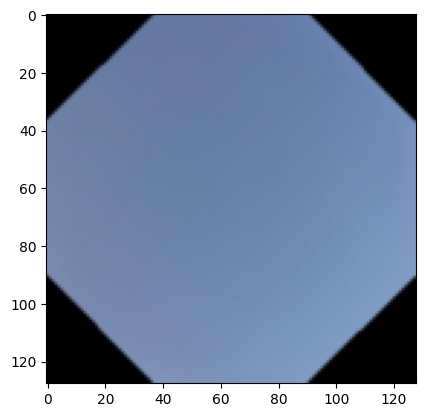

In [105]:
import matplotlib.pyplot as plt
dataloader_train = DataLoader(
    train_data, 
    shuffle = True, 
    batch_size = 1, 
)

dataloader_test = DataLoader(
    test_data, 
    shuffle=False, 
    batch_size=1,
)

image, label = next(iter(dataloader_train))
print(image.shape) 
image = image.squeeze().permute(1, 2, 0) #Rearrange Dimensions
print(image.shape)

plt.imshow(image)
plt.show()

torch.Size([1, 3, 128, 128])
torch.Size([128, 128, 3])


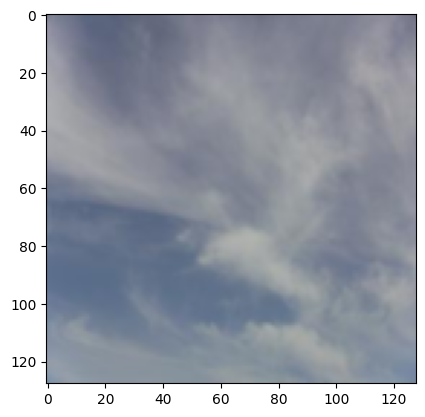

In [114]:
image, label = next(iter(dataloader_test))
print(image.shape) 
image = image.squeeze().permute(1, 2, 0) #Rearrange Dimensions
print(image.shape)
plt.imshow(image)
plt.show() 


## Applying Convolutional Neural Network (CNN)

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module): 
    def __init__(self, num_classes): 
        super(Net, self).__init__()
        
        # Define the feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.ELU(), 
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.ELU(), 
            nn.MaxPool2d(kernel_size=2), 
            nn.Flatten()
        )
        
        self.classifier = None
        self.num_classes = num_classes

    def forward(self, x): 
        x = self.feature_extractor(x)
        #print(f"Shape after feature extractor: {x.shape}")  # Debugging shape print
        if self.classifier is None:
            self.classifier = nn.Linear(x.size(1), self.num_classes).to(x.device)
            #print(f"Initialized classifier with input size: {x.size(1)}")  # Confirm classifier init
        x = self.classifier(x)
        #print(f"Shape after classifier: {x.shape}")  # Final shape debug
        return x 

# Test the model on dummy input to verify shapes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(num_classes=7).to(device)

dummy_input = torch.randn(1, 3, 128, 128).to(device)  
output = net(dummy_input)  
print(f"Final output shape: {output.shape}")  # Should be [1, 7] if correct '''


Final output shape: torch.Size([1, 7])


## Image Classifier Training Loop 

In [128]:
# Define the model
net = Net(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
 
    for images, labels in dataloader_train:
        
        images, labels = images.to(device), labels.to(device) # Move images and labels to the GPU
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.7277
Epoch 2, Loss: 1.5539
Epoch 3, Loss: 1.4660
Epoch 4, Loss: 1.4159
Epoch 5, Loss: 1.3600
Epoch 6, Loss: 1.3297
Epoch 7, Loss: 1.3173
Epoch 8, Loss: 1.3327
Epoch 9, Loss: 1.2913
Epoch 10, Loss: 1.2689


## Model Evaluation

In [132]:
from torchmetrics import Precision, Recall 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


metric_precision = Precision( 
    task='multiclass', num_classes=7, average='macro'
).to(device)

metric_recall = Recall(
    task='multiclass', num_classes=7, average=None #performance per class
).to(device)

net.eval()
with torch.no_grad(): 
    for images, labels in dataloader_test: 
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)
percision = metric_precision(preds, labels)
recall = metric_recall.compute()

print(f"Precision: {precision}")
print(f"Recal : {recall}")




Precision: 0.5828217267990112
Recal : tensor([0.0779, 0.9844, 0.5455, 0.2250, 0.7961, 0.5000, 0.1549],
       device='cuda:0')


In [118]:
test_data.class_to_idx

{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}

In [119]:
{
    k: recall[v].item()
    for k, v 
    in test_data.class_to_idx.items()
}

{'cirriform clouds': 0.33766233921051025,
 'clear sky': 0.984375,
 'cumulonimbus clouds': 0.5454545617103577,
 'cumulus clouds': 0.4833333194255829,
 'high cumuliform clouds': 0.42718446254730225,
 'stratiform clouds': 0.6000000238418579,
 'stratocumulus clouds': 0.39436620473861694}